# 一. 感知机(Perceptron)

感知机由`Frank Roseblatt`于1957年提出，是一种广为使用的线性分类模型。感知机是最简单的神经网络，只有1个神经元。

感知机是对生物神经元的简单数学模拟，有与生物神经相对应的部件，如权重（突触）、偏置（阈值）及激活函数（细胞体），输出为+1或-1。

感知机是二分类线性模型，对应于输入空间中将实例划分为正负两类的分离超平面，属于判别模型。

感知机学习旨在求出将训练数据进行线性划分的分离超平面。为此，基于误分类的损失函数，利用梯度下降法对损失函数进行极小化，求得感知机模型。

## 1. 模型

定义2.1 （感知机） 假设输入空间是$\mathbf{X} \subseteq \mathbb{R^n}$，输出空间是$\mathbf{Y}=\{+1,-1\}$。输入$x\in \mathbf{X}$表示实例的特征向量，对应于输入空间的点；输出$y\in \mathbf{Y}$表示实例的类别。由输入空间到输出空间的如下函数
$$
f(x)=\mathrm{sign} (\omega\cdot x+b)
$$
称为感知机。其中，$\omega$和$b$为感知机模型参数，$\omega\in\mathbb{R^n}$为权重值或者权值向量，$b\in\mathbb{R}$称为偏置。$sign$是符号函数，即
$$
\begin{equation}
\mathrm{sign}(x)=\begin{cases}
+1,x\geq 0 \\
-1,x<0
\end{cases}
\end{equation}
$$
感知机的假设空间是定义在特征空间上的所有线性分类模型或线性分类器，即函数集合$\{f|f(x)=\omega\cdot x + b\}$

In [1]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import set_matplotlib_formats
import torch

生成示例数据集

In [98]:
x0 = torch.randn(100, 2) + 2  # 均值为 2 正例
y0 = torch.ones(100)
x1 = torch.randn(100, 2) - 2  # 均值为 -2  反例
y1 = -torch.ones(100)

x = torch.cat((x0, x1)).type(torch.FloatTensor)  # 整合成一个数据集
y = torch.cat((y0, y1)).type(torch.LongTensor)  # 整合成一个标签集

定义感知机函数

In [2]:
def percetron(w, X, b):
    '''
    w: 参数向量 n, 1
    X: 矩阵 m, n
    b: 偏置，标量
    '''
    z = X@w + b
    y = torch.ones_like(z)
    y[torch.lt(z, 0)] = -1  # 小于0的值为-1，大于等于0的值为1
    return y

In [106]:
w  = torch.tensor([[2.0], [1.0]])
b = 1.0

In [108]:
pred_y = percetron(w, x, b)

In [109]:
idx = np.arange(len(x))  # 生成数据集的下标
np.random.shuffle(idx)  # 随机打乱索引次序
train_x, train_y = x[idx[:50]], y[idx[:50]]  # 选取前50个和后50个
test_x, test_y = x[idx[50:]], y[idx[50:]]

In [110]:
x_list = [train_x, test_x]
y_list = [train_y, test_y]

绘图

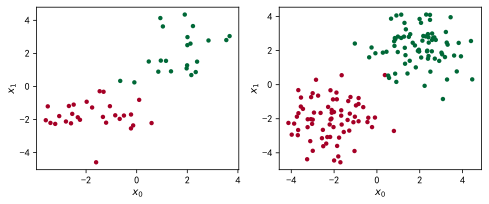

In [111]:
fig = plt.figure(figsize=(8, 3))
for i in range(2):
    px = x_list[i]
    py = y_list[i]
    ax = fig.add_subplot(1, 2, i+1)
    ax.set_xlabel('$x_0$')
    ax.set_ylabel('$x_1$')
    ax.scatter(px.data.numpy()[:,0], px.data.numpy()[:,1], c=py.data.numpy(), s=20, lw=0, cmap='RdYlGn')

## 2. 学习策略

### 2.1 数据集的线性可分性

定义2.2 （数据集的线性可分性）给定一个数据集
$$
T=\{(x_1,y_1),(x_2,y_2),...,(x_N,y_N)\}
$$
其中，$x_i\in \mathbf{X}=\mathrm{R^n},y_i\in\mathrm{Y}=\{+1,-1\},i=1,2,...,N$，如果存在某个超平面S
$$
\omega\cdot x + b=0
$$
能够将数据集的正实例点和负实例点完全正确地划分到超平面的两侧，即对所有的$y_i=+1$的实例i，有$\omega\cdot x_i+b>0$，对所有的$y_i=-1$的实例i，有$\omega\cdot x_i+b<0$，则称数据集$T$为线性可分数据集；否则，称之为线性不可分。

### 2.2 感知机学习策略

假设训练数据集是线性可分的，感知机学习的目标是求得一个能够将训练集正负实例完全正确分开的分离超平面。

损失函数：误分类点到超平面S的总距离。

输入空间$\mathrm{R^n}$中任意点$x_0$到超平面S的距离
$$
\mathrm{dist(x_0,S)}=\frac{1}{\|\omega\|}|\omega\cdot x_0+b|
$$
这里，$\|\omega\|$是$\omega$的$L_2$范数。

> 假定$x=\left(x_1, x_2, ..., x_n\right)$,
> - $L_1$范的定义: $\Vert x\Vert_1=\sum_{i=1}^n|x_i|$
> - $L_2$范的定义: $\Vert x\Vert_2=\sqrt{\sum_{i=1}^nx^2_i}$

对于误分类数据点$(x_i,y_i)$，有$-y_i(\omega\cdot x_i+b)>0$成立。因此
$$
\mathrm{dist(x_0,S)}=-\frac{1}{\|\omega\|}y_i(\omega\cdot x_0+b)
$$

假定`S`的误分类集合为`M`，则所有误分类点到超平面的距离总和为
$$
\mathrm{Dist(M,S)}=-\frac{1}{\|\omega\|}\sum_{x_i\in M}y_i(\omega\cdot x_i+b)
$$
如果不考虑$\frac{1}{\|\omega\|}$，就得到了感知机学习的损失函数。
$$
L(\omega,b)=-\sum_{x_i\in M}y_i(\omega\cdot x_i+b)
$$
显然，以上损失函数是非负的，如果没有误分类点，则损失函数为0.

In [121]:
def loss(w, b, X, y):  # 所有误分类点的误差和
    '''
    w: 权重(参数)向量 (n, 1)
    X: 特征矩阵 (m, n)
    y: 标签向量 (m, 1)
    b: 偏置, 标量
    注意，为了构建计算图，w, b必须为torch.tensor()
    '''
    hat_y = X@w + b  # 预测值
    # 预测标签和实际标签之积再乘以-1, 误分类点对应的值为正, 正确分类点对应的值为负
    neg_Dist = -hat_y.reshape(1, -1) * y.reshape(1, -1)
    return torch.sum(neg_Dist[neg_Dist > 0])  # 取所有正值(即误分类点)的和
#     return torch.sum(torch.relu(neg_Dist))  # relu取所有正值, 负值重置为0

> `ReLU(Rectified Linear Unit, ReLU)`函数又称为修正线性单元, 是神经元的常用激活函数之一。
> $$ \mathrm{ReLU(x)=\max{(0,x)}}$$

In [124]:
w  = torch.tensor([[2.0], [1.0]])
b = 1.0
print(loss(w, b, train_x, train_y), loss(w, b, test_x, test_y))

tensor(0.3858) tensor(2.3086)


In [113]:
a = torch.randn(10)
print(a)
print(torch.relu(a))
print(torch.sum(torch.relu(a)))

tensor([ 0.8061, -0.6677, -0.0451, -0.3738, -0.0297, -0.1795, -1.0718, -0.9382,
        -0.3810,  0.3126])
tensor([0.8061, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.3126])
tensor(1.1187)


## 3. 感知机学习算法原始形式

感知机的学习问题即$L(\omega, b)$的极小化问题

$$
\min_{\omega, b}L(\omega, b)=-\sum_{x_i\in M}y_i(\omega\cdot x_i + b)
$$

感知机是误分类驱动的，具体可采用不同的方法，如**梯度下降法、随机梯度下降法**等。

假设误分类集合`M`是固定的，那么损失函数$L(\omega, b)$的梯度由
$$
\bigtriangledown_{\omega}L(\omega, b)=-\sum_{i\in M}y_ix_i \\
\bigtriangledown_{b}L(\omega, b)=-\sum_{i\in M}y_i
$$
给出。

随机选取一个误分类点$(x_i,y_i)\in M$，对$\omega, b$进行更新：

$$
\omega := \omega + \eta y_i x_i \\
b := b + \eta y_i
$$

其中$0<\eta\leq 1$是步长，也称为学习率。通过迭代可以减少损失函数$L(\omega, b)$的值，直到为0.

>算法2.1  (感知机学习算法的原始形式)
>
>输入：训练数据集$T=\{(x_1,y_1),(x_2,y_2),...,(x_N,y_N)\}$，其中$x_i\in \mathbf{X=R^n}, y_i\in Y=\{-1, +1\}, i=1,2,...,N$; 学习率$\eta(0<\eta\leq 1)$；
>
>输出：$\omega,b$; 感知机模型$f(x)=\mathrm{sign}(\omega\cdot x+b)$
>
>算法过程：
>
>(1) 选取初值$\omega_0, b_0$;
>
>(2) 对于$i\in T$，根据$y_i(\omega\cdot x_i+b)\lt 0$获取误分类点集合M
>
>(3) 在M中随机选取数据$(x_i, y_i)$;
>
>(3) 如果$(y_i(\omega\cdot x_i+b))\lt 0$,
$$
\omega := \omega + \eta y_i x_i \\
b := b + \eta y_i
$$
>(4) 若$M=\emptyset$，则结束算法；否则，转至(2)

In [125]:
def learn_perceptron_sgd(X, y, epochs=100, lr=0.03):
    '''
    X: 训练集特征矩阵
    y: 训练集标签
    epochs: 最大训练批次
    lr: 学习率
    '''
    w = torch.randn(size=(X.shape[1], 1))   # 初始化权重向量
    b = torch.zeros(size=(1, ))  # 初始化偏置
    s_indices = np.arange(X.shape[0])  # 训练样本下标构成的数列
    for epoch in range(epochs):
        np.random.shuffle(s_indices)  # 随机打乱s_indices
        for i in s_indices:  #
            x_i = X[i]
            y_i = y[i]
            if (x_i @ w + b) * y_i < 0: # 选择第一个分错的点更新
                w = w + (lr*y_i*x_i).reshape(-1, 1)
                b = b + lr*y_i
                break  # 更新一个误分类点后跳出循环，进行下一轮
        else:  # 如果所有节点被正确分类，则跳出迭代
            print(f'迭代在{epoch+1}次结束, 所有数据点已被正确分类!')
            break
    return w, b

In [126]:
w, b = learn_perceptron_sgd(train_x, train_y)
print(w, b)

迭代在12次结束, 所有数据点已被正确分类!
tensor([[0.0731],
        [0.1480]]) tensor([0.0300])


- 采用梯度下降法进行训练
>利用所有误分类点计算损失函数

In [127]:
def learn_model(lossfunc, X, y, epochs=50, lr=0.03):
    '''
    lossfunc: 损失函数
    X: 特征矩阵
    y: 标签
    epochs: 训练批次
    lr: 学习率
    '''
    w = torch.randn(size=(X.shape[1], 1), requires_grad=True)  # 设置需求梯度的tensor
    b = torch.zeros(size=(1, ), requires_grad=True)
    for epoch in range(epochs):
        l = lossfunc(w, b, X, y)  # 计算损失函数
        l.backward()  # 反向传播误差
        w.data.sub_(lr*w.grad)  # 更新权重
        w.grad.data.zero_()  # 重置w的梯度为0
        b.data.sub_(lr*b.grad)  # 更新偏置
        b.grad.data.zero_()  # 重置b的梯度为0
        with torch.no_grad():  # 不计算梯度，加速损失函数的运算
            d_w, d_b = w.detach(), b.detach()  #  从计算图中解绑，后面的操作不影响计算图中对应的结果
            train_l = lossfunc(d_w, d_b, X, y)  # 最近一次的负对数似然率
            if epoch % 5 == 0:
                print(f'epoch {epoch}, loss: {train_l.numpy():.4f}')
    return w, b

In [128]:
def failure_ratio(w, b, feature, true_label):
    predict_label = percetron(w, feature, b)
    sum_mis = torch.sum(torch.relu(-true_label.reshape(1, -1) * predict_label.reshape(1, -1)))  # 误分类的个数：感知机预测值与实际标签符号不一致的数量
    return sum_mis.data.numpy() / len(true_label)

In [129]:
w, b = learn_model(loss, train_x, train_y, epochs=20)
print('训练结果:', w, b)
print('误分类率:', failure_ratio(w, b, train_x, train_y))

epoch 0, loss: 0.0000
epoch 5, loss: 0.0000
epoch 10, loss: 0.0000
epoch 15, loss: 0.0000
训练结果: tensor([[0.1757],
        [2.3162]], requires_grad=True) tensor([-0.2100], requires_grad=True)
误分类率: 0.0


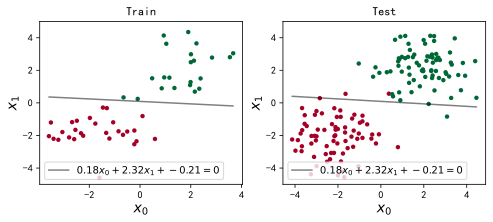

In [130]:
d_w = w.data.numpy()
d_b = b.data.numpy()
w0, w1 = d_w.reshape(1, -1)[0]
b = d_b[0]
title_list = ['Train', 'Test']

fig = plt.figure(figsize=(8, 3))
for i in range(2):
    px = x_list[i]
    py = y_list[i]
    x0 = px.data.numpy()[:,0]
    x1 = px.data.numpy()[:,1]
    y = -(w0*x0+b) / w1  # 超平面
    ax = fig.add_subplot(1, 2, i+1)
    ax.set_title(title_list[i])
    ax.set_xlabel('$x_0$', fontsize=14)
    ax.set_ylabel('$x_1$', fontsize=14)
    ax.scatter(x0, x1, c=py.data.numpy(), s=20, lw=0, cmap='RdYlGn')
    ax.set_ylim([-5, 5])
    ax.plot(x0, y, 'k-', alpha=0.5, label=f"${w0:.2f}x_0+{w1:.2f}x_1+{b:0.2f}=0$")
    ax.legend(loc='best')

## 4. 感知机学习算法对偶形式

增广参数$\hat{\omega}=(\mathbf{\omega}, b)$:
$$
\begin{aligned}
\mathbf{\hat{\omega}} &=  (\omega_1, \omega_2, ..., \omega_n, b) \\
&= (\sum_{i=1}^N \alpha_i y_i x_i^1, \sum_{i=1}^N \alpha_i y_i x_2^2, ..., \sum_{i=1}^N \alpha_i y_i x_i^n, \sum_{i=1}^N \alpha_i y_i) \\
&= (\mathbf{\alpha_{1\times N} \odot y_{1\times N}^T) X_{N\times (n+1)}}
\end{aligned}
$$
其中$\mathbf{\alpha}=(\alpha_1, \alpha_2, ..., \alpha_N)$是针对各数据点的更新累积量。例如，如果针对点0更新了4次，则对应有$\alpha_0=4\eta$，$\eta$为学习率。

感知机为
$$
f(x_i) = \mathbf{\hat{\omega}\hat{x_i}^T}
$$
其中$\mathbf{\hat{x_i}}=(x_i^1, x_i^2, ..., x_i^n, 1)$。

可以先计算$\mathbf{A} = \hat{X}_{N\times (n+1)} \hat{X}_{(n+1)\times N}^T$，迭代更新遇到误分类点$x_i$时，直接取对应的列$A_{.,i}$，即计算$(\mathbf{\alpha_{1\times N} \odot y_{1\times N}^T) A_{.,i}}$。由于$X$和$y$是已知的，因此只需更新$\alpha$即可，从而减小了计算量。

>算法2.2 （感知机学习算法的对偶形式）
>输入：训练数据集$T=\{(x_1,y_1),(x_2,y_2),...,(x_N,y_N)\}$，其中$x_i\in \mathbf{X=R^n}, y_i\in Y=\{-1, +1\}, i=1,2,...,N$; 学习率$\eta(0<\eta\leq 1)$；
>
>输出：$\mathbf{\alpha},b$, 其中$\mathbf{\alpha}=(\alpha_1,\alpha_2,...,\alpha_N)^T$为各数据点更新的次数; 感知机模型$f(x)=\mathrm{sign}(\sum_{j=1}^N \alpha_jy_j\cdot \mathbf{x} +b)$
>
>算法过程：
>
>(1) $\alpha := (0, 0, ..., 0)^T$, b:= 0;
>
>(2) 在训练集T中根据$y_i\left(\left(\sum_{j=1}^N\alpha_j y_j x_j\right)\cdot x_i+b\right)\leq 0$随机选取一个误分类数据$(x_i,y_i)$;
>> $y_i\left(\left(\alpha\cdot y\right)x x_i^T+b\right) \leq 0$

>(3) 执行更新$\alpha_i:=\alpha_i+\eta,b:=b+\eta y_i$;
>
>(4) 转至(2)直到没有误分类点

如果数据点维度`n`很大，且数据集样本数量`N`较小，则由于只需计算一次$XX^T$，更新过程只需记录$\omega, b$的更新过程，可降低计算复杂度。

In [131]:
a = torch.tensor([[1, 2, 3],
                 [4, 5, 6]])

a @ a.t()  # a的gram矩阵

tensor([[14, 32],
        [32, 77]])

In [132]:
a = torch.tensor([1, 2, 3])
a @ a.t()  # a的gram矩阵

tensor(14)

In [133]:
def learning_perceptron_dual_sgd(X, y, epochs=100, lr=0.03):
    '''
    X: 特征矩阵 N*n
    y: 标签 N*1
    epochs: 最大训练批次
    lr: 学习率
    '''
    gram = X @ X.t()  # 求X的Gram矩阵 (N, N)，为对称方阵
    alpha = torch.zeros(X.shape[0])  # 初始化误分类的更新累积量 (N,1)
    b = torch.zeros(1)
    s_indices = np.arange(X.shape[0])  # 训练样本的下标
    for epoch in range(epochs):
        np.random.shuffle(s_indices)  # 随机打乱s_idx
        for i in s_indices:
            if (alpha * y @ gram[i] + b) * y[i] <= 0: # 选择第一个分错的点更新
                alpha[i] = alpha[i] + lr
                b = b + lr * y[i]
                break  # 更新一个误分类点后跳出循环，进行下一轮
        else:  # 如果所有节点被正确分类，则跳出迭代
            print(f'迭代在{epoch+1}次结束, 所有数据点已被正确分类!')
            break
            
    w = train_y * alpha @ train_x  # 对应的w
    return w, b, alpha

In [134]:
def learning_perceptron_dual_sgd_2(X, y, epochs=1000, lr=0.03):
    '''
    X: 特征矩阵 N*n
    y: 标签
    epochs: 最大训练批次
    lr: 学习率
    '''
    gram = X @ X.t()  # 求X的Gram矩阵 (N, N)，为对称矩阵
    alpha = torch.zeros(X.shape[0])  # 误分类的更新累积量
    b = torch.zeros(1)
    s_indices = np.arange(X.shape[0])
    for epoch in range(epochs):
        d = (alpha * y @ gram + b) * y  # 计算所有数据点的判断条件
        neg_indices = s_indices[d <= 0]  # 获取为分类错误的实例
        if len(neg_indices) > 0:  # 如果有，则更新
            c_idx = np.random.choice(neg_indices)
            alpha[c_idx] = alpha[c_idx] + lr
            b = b + lr*y[i]
        else:
            break

    print(f'经过{epoch+1}次训练后，已分类完成')
    w = train_y * alpha @ train_x  # 对应的w
    return w, b, alpha

In [135]:
w, b, alpha = learning_perceptron_dual_sgd_2(train_x, train_y, epochs=100, lr=0.01)

经过2次训练后，已分类完成


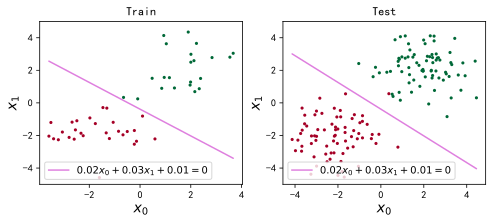

In [136]:
d_w = w.data.numpy()
d_b = b.data.numpy()
w0, w1 = d_w.reshape(1, -1)[0]
b = d_b[0]
title_list = ['Train', 'Test']

fig = plt.figure(figsize=(8, 3))
for i in range(2):
    px = x_list[i]
    py = y_list[i]
    x0 = px.data.numpy()[:,0]
    x1 = px.data.numpy()[:,1]
    y = -(w0*x0+b) / w1  # 超平面
    ax = fig.add_subplot(1, 2, i+1)
    ax.set_title(title_list[i])
    ax.set_xlabel('$x_0$', fontsize=14)
    ax.set_ylabel('$x_1$', fontsize=14)
    ax.scatter(x0, x1, c=py.data.numpy(), s=10, lw=0, cmap='RdYlGn')
    ax.set_ylim([-5, 5])
    ax.plot(x0, y, 'm-', alpha=0.5, label=f"${w0:.2f}x_0+{w1:.2f}x_1+{b:0.2f}=0$")
    ax.legend(loc='best')

## 5. 感知机应用

目标: 训练一个感知机对来自20Newsgroups数据集的文档进行分类。该数据集包含了来自20个Usenet新闻组约20000份文档样本。我们将训练一个感知机对3个新闻组的文档进行分类，它们分笔试rec.sport.hockey新闻组、rec.sport.baseball新闻组和rec.auto新闻组。感知机使用“1对多”的策略来续联数据中的每个类训练分类器，以此进行多类别分类。
> 该数据集有20类: `['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']`

In [137]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Perceptron
from sklearn.metrics import f1_score, classification_report

- 获取数据集

In [138]:
categories = ['rec.sport.hockey', 'rec.sport.baseball', 'rec.autos']
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories, remove=('headers', 'footers', 'quotes'))

> `newsgroups_train`和`newsgroups_test`为包含特征data和类别target

In [139]:
for i in range(2):
    print(newsgroups_test.data[i], '\n', newsgroups_test.target[i])

Newsgroups: rec.sport.baseball




Harry talks about this "incident" in his autobiography "Holy Cow."  
Unfortunately, I can not clarify on this since (1) I read the book a couple
of years ago and (2) I do not have my book with me.  

Anyway, It is a pretty interesting book if you are a Harry or Cubs fan. 
 1
I'm
the
tickets

Grrrr, let's start a whole 'nother topic on show bad the sharks are doing on
these things. I swear that ALL of my partial plan games were televised (I
know, I'm exaggerating, but...).
In order:
-the new ticket prices suck
-wait 'till people try to park at games next year. Public transit? Yeah
right, I'd love to take caltrain for 3 hours to see a 3 hour game.

Shelling out hundreds of dollars for partial season plans for two years
doesnt mean anything to the sharks, as I get to pick my seats after the dead
rise from their graves to claim their seats! :-)
-Frank 
 2


- 将文本中的单词转换为tf-idf
> $\mathrm{tf(t,d)=\frac{f(t,d)}{\Vert x \Vert}}$, $\mathrm{idf(t, D)=\log{\frac{N}{1+|d\in D:t\in d|}}}$

In [140]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(newsgroups_train.data)
X_test = vectorizer.transform(newsgroups_test.data)

In [141]:
X_train

<1791x18242 sparse matrix of type '<class 'numpy.float64'>'
	with 141190 stored elements in Compressed Sparse Row format>

In [142]:
len(newsgroups_train.target)

1791

In [143]:
clf = Perceptron(random_state=11)
clf.fit(X_train, newsgroups_train.target)

Perceptron(random_state=11)

In [144]:
predictions = clf.predict(X_test)
print(classification_report(newsgroups_test.target, predictions))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88       396
           1       0.82      0.83      0.83       397
           2       0.88      0.87      0.87       399

    accuracy                           0.86      1192
   macro avg       0.86      0.86      0.86      1192
weighted avg       0.86      0.86      0.86      1192



- 应用于以上人工数据集

In [145]:
clf0 = Perceptron(random_state=0)
clf0.fit(train_x.numpy(), train_y.numpy())

Perceptron()

In [146]:
predictions0 = clf0.predict(test_x)
print(classification_report(test_y, predictions0))

              precision    recall  f1-score   support

          -1       1.00      0.99      0.99        72
           1       0.99      1.00      0.99        78

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150



### 附. 梯度下降

考虑$\mathbf{x} \in \mathbb{R}^d$, 其中$\mathbf{x}$为向量, 目标函数$f: \mathbb{R}^d \to \mathbb{R}$映射至标量。对应的$f$关于$\mathbf{x}$每一维度$x_i$的偏导构成梯度

$$\nabla f(\mathbf{x}) = \bigg[\frac{\partial f(\mathbf{x})}{\partial x_1}, \frac{\partial f(\mathbf{x})}{\partial x_2}, \ldots, \frac{\partial f(\mathbf{x})}{\partial x_d}\bigg]^\top.$$

利用泰勒展开式可得

$$f(\mathbf{x} + \Delta x) = f(\mathbf{x}) + \Delta\mathbf{x}^\top \nabla f(\mathbf{x}) + O(|\mathbf{\Delta x}|^2).$$ 

在给定$\Vert\Delta x\Vert^2=1$的条件下，下一步应该怎么走才能最大程度地减少$f$呢？

最速下降方向由$-\nabla f(\mathbf{x})$给出。令$\Delta \mathbf{x}=-\eta \nabla f(\mathbf{x})$

$$f(\mathbf{x} + \Delta x) = f(\mathbf{x}) - \eta \nabla f(\mathbf{x})^T \nabla f(\mathbf{x}) + O(|\Delta x|^2).$$ 

选定合适的学习率$\eta > 0$，则可得梯度下降更新公式

$$\mathbf{x} \leftarrow \mathbf{x} - \eta \nabla f(\mathbf{x}).$$

In [147]:
def grad_desc(f, grad_f, x0, learn_rate=0.05):
    '''
    f: 待优化目标函数, grad_f: f的梯度, x0: 参数初值, learn_rate: 学习率
    '''
    trace_x = np.array([x0])  # x的遍历历史记录
    x = x0
    i = 0
    while True:
        x = x - learn_rate * grad_f(x)  # 更新x的值
        trace_x = np.concatenate([trace_x, x.reshape(1, -1)])
        i += 1
        if i % 5 == 0:
            print(f'迭代次数: {i}, 目标函数值f: {f(x):.6f}')

        if np.sum(np.abs(trace_x[-1] - trace_x[-2])) < 1e-3:  # 停止条件
            break

    print(f'共迭代 {len(trace_x)}次, 最优参数值为: {x.tolist()}')
    return trace_x

In [148]:
def f(x):
    return x[0]**2 + 2 * x[1]**2   # objective

def grad_f(x):
    return np.array([2 * x[0], 4 * x[1]])    # gradient

迭代次数: 5, 目标函数值f: 0.054421
迭代次数: 10, 目标函数值f: 0.000329
迭代次数: 15, 目标函数值f: 0.000002
共迭代 16次, 最优参数值为: [0.001410554953727999, 9.830399999999963e-11]


Text(0, 0.5, '$x_1$')

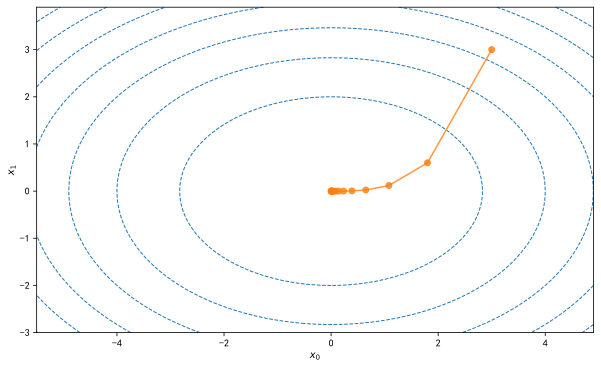

In [149]:
res = grad_desc(f, grad_f, x0=np.array([3, 3]), learn_rate=0.2)

x0, x1 = res[:, 0], res[:, 1]
plt.figure(figsize=(10, 6))
plt.plot(x0, x1, '-o', color='#ff7f0e', alpha=0.8)
x0 = np.arange(-5.5, 5.0, 0.1)
x1 = np.arange(min(-3.0, min(x1) - 1), max(1.0, max(x1) + 1), 0.1)
x0, x1 = np.meshgrid(x0, x1)
plt.contour(x0, x1, f([x0, x1]), colors='#1f77b4', linewidths=1, linestyles='dashed')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')